# Fast Bayesian estimation of SARIMAX models

## Introduction

This notebook will show how to use fast Bayesian methods to estimate SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors) models. These methods can also be parallelized across multiple cores.

Here, fast methods means a version of Hamiltonian Monte Carlo called the No-U-Turn Sampler (NUTS) developed by Hoffmann and Gelman: see [Hoffman, M. D., & Gelman, A. (2014). The No-U-Turn sampler: adaptively setting path lengths in Hamiltonian Monte Carlo. Journal of Machine Learning Research, 15(1), 1593-1623.](https://arxiv.org/abs/1111.4246). As they say, "the cost of HMC per independent sample from a target distribution of dimension $D$ is roughly $\mathcal{O}(D^{5/4})$, which stands in sharp contrast with the $\mathcal{O}(D^{2})$ cost of random-walk Metropolis". So for problems of larger dimension, the time-saving with HMC is significant. However it does require the gradient, or Jacobian, of the model to be provided.

This notebook will combine the Python libraries [statsmodels](https://www.statsmodels.org/stable/index.html), which does econometrics, and [PyMC3](https://docs.pymc.io/), which is for Bayesian estimation, to perform fast Bayesian estimation of a simple SARIMAX model, in this case an ARMA(1, 1) model for US CPI.

Note that, for simple models like AR(p), base PyMC3 is a quicker way to fit a model; there's an [example here](https://docs.pymc.io/notebooks/AR.html). The advantage of using statsmodels is that it gives access to methods that can solve a vast range of statespace models.

The model we'll solve is given by

$$
y_t = \phi y_{t-1} + \varepsilon_t + \theta_1 \varepsilon_{t-1}, \qquad \varepsilon_t \sim N(0, \sigma^2)
$$

with 1 auto-regressive term and 1 moving average term. In statespace form it is written as:

$$
\begin{align}
y_t & = \underbrace{\begin{bmatrix} 1 & \theta_1 \end{bmatrix}}_{Z} \underbrace{\begin{bmatrix} \alpha_{1,t} \\ \alpha_{2,t} \end{bmatrix}}_{\alpha_t} \\
    \begin{bmatrix} \alpha_{1,t+1} \\ \alpha_{2,t+1} \end{bmatrix} & = \underbrace{\begin{bmatrix}
        \phi & 0 \\
        1      & 0     \\
    \end{bmatrix}}_{T} \begin{bmatrix} \alpha_{1,t} \\ \alpha_{2,t} \end{bmatrix} +
    \underbrace{\begin{bmatrix} 1 \\ 0 \end{bmatrix}}_{R} \underbrace{\varepsilon_{t+1}}_{\eta_t} \\
\end{align}
$$

The code will follow these steps:
1. Import external dependencies
2. Download and plot the data on US CPI
3. Simple maximum likelihood estimation (MLE) as an example
4. Definitions of helper functions to provide tensors to the library doing Bayesian estimation
5. Bayesian estimation via NUTS
6. Application to US CPI series

Finally, Appendix A shows how to re-use the helper functions from step (4) to estimate a different state space model, `UnobservedComponents`, using the same Bayesian methods.

### 1. Import external dependencies

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import statsmodels.api as sm
import theano
import theano.tensor as tt
from pandas.plotting import register_matplotlib_converters
from pandas_datareader.data import DataReader

plt.style.use("seaborn")
register_matplotlib_converters()

/tmp/ipykernel_4846/3117040453.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


### 2. Download and plot the data on US CPI

We'll get the data from FRED:

In [2]:
cpi = DataReader("CPIAUCNS", "fred", start="1971-01", end="2018-12")
cpi.index = pd.DatetimeIndex(cpi.index, freq="MS")

# Define the inflation series that we'll use in analysis
inf = np.log(cpi).resample("QS").mean().diff()[1:] * 400
inf = inf.dropna()
print(inf.head())

            CPIAUCNS
DATE                
1971-04-01  4.316424
1971-07-01  4.279518
1971-10-01  1.956799
1972-01-01  2.917767
1972-04-01  3.219096


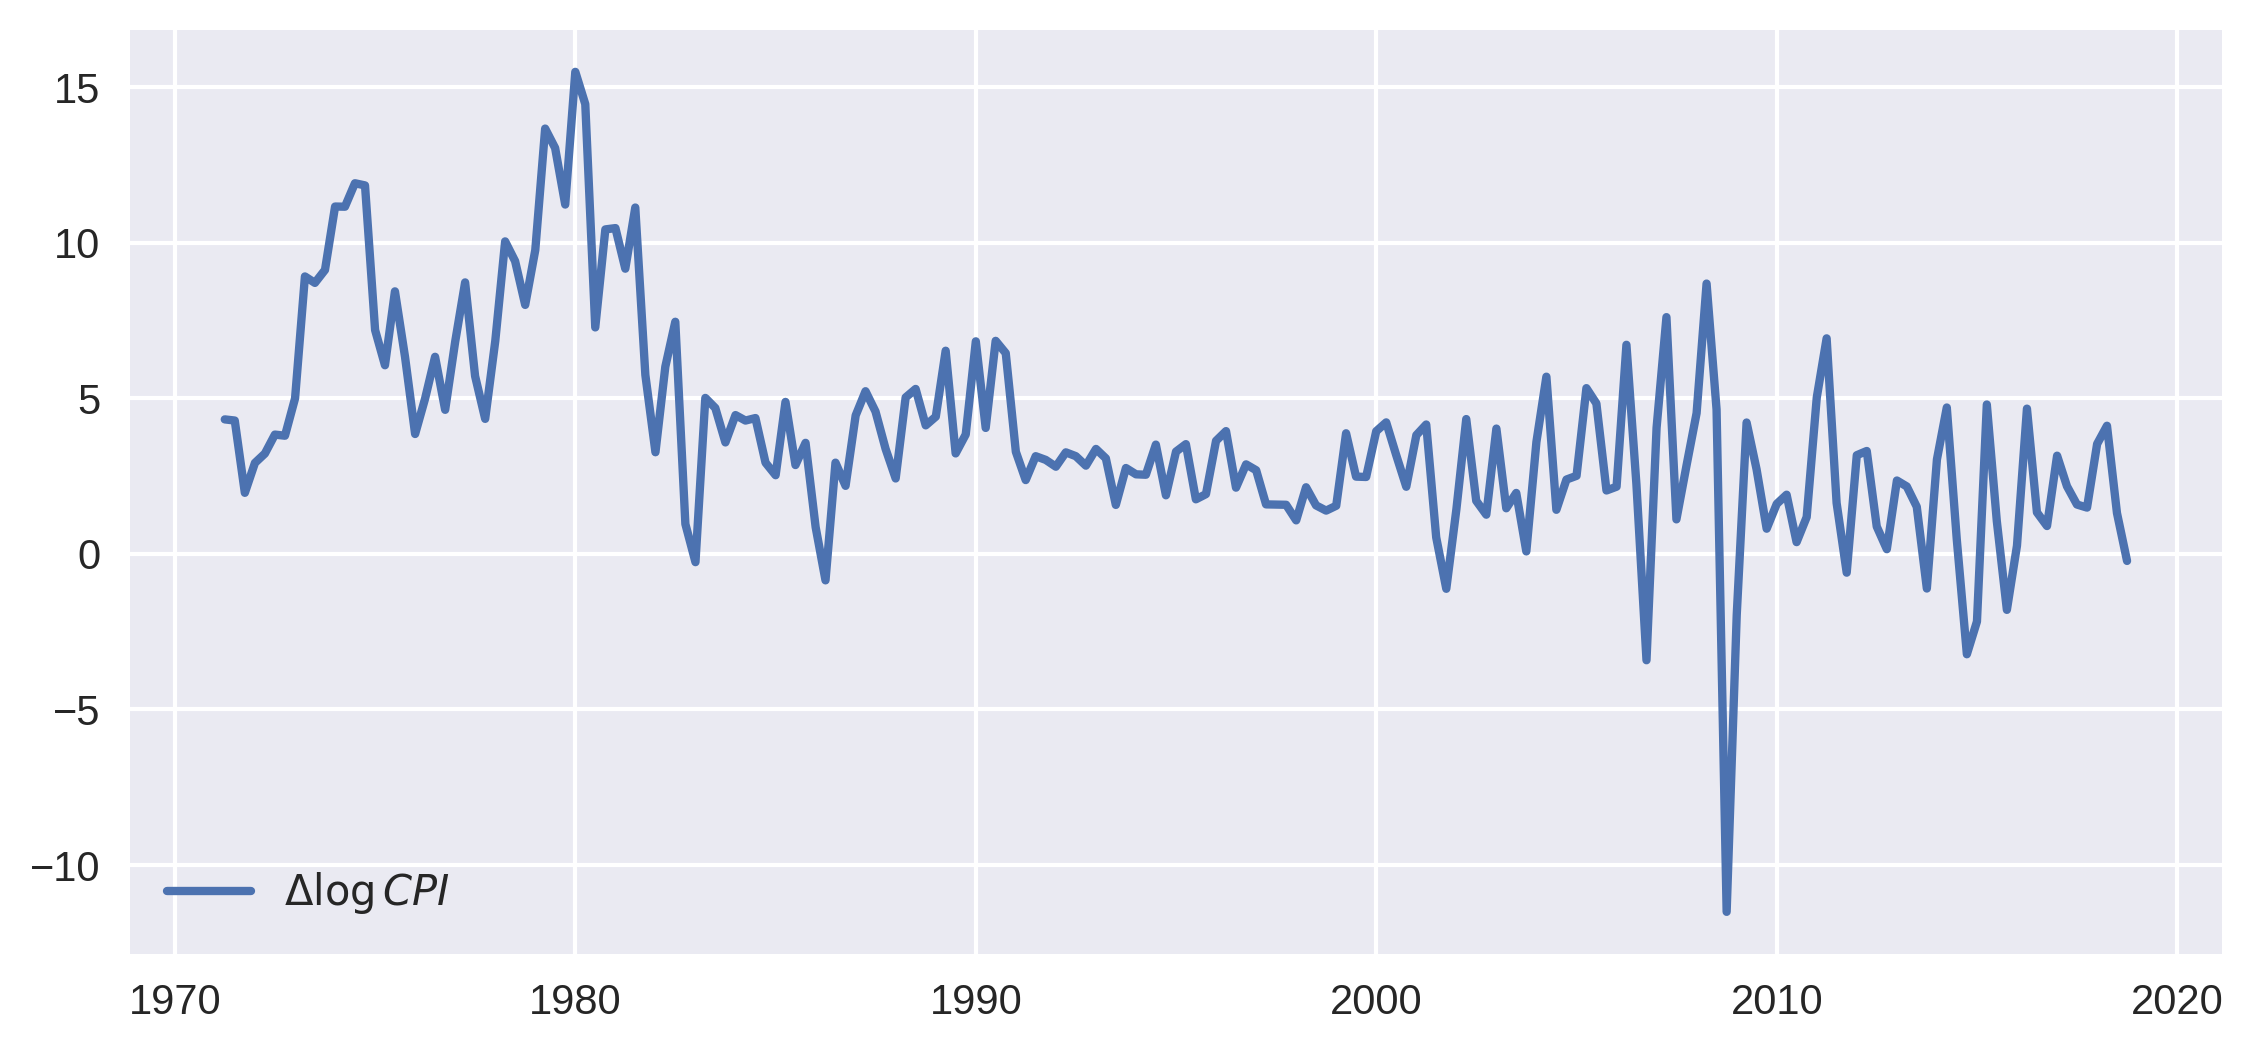

In [3]:
# Plot the series
fig, ax = plt.subplots(figsize=(9, 4), dpi=300)
ax.plot(inf.index, inf, label=r"$\Delta \log CPI$", lw=2)
ax.legend(loc="lower left")
plt.show()

### 3. Fit the model with maximum likelihood

Statsmodels does all of the hard work of this for us - creating and fitting the model takes just two lines of code. The model order parameters correspond to auto-regressive, difference, and moving average orders respectively.

In [4]:
# Create an SARIMAX model instance - here we use it to estimate
# the parameters via MLE using the `fit` method, but we can
# also re-use it below for the Bayesian estimation
mod = sm.tsa.statespace.SARIMAX(inf, order=(1, 0, 1))

res_mle = mod.fit(disp=False)
print(res_mle.summary())

                               SARIMAX Results                                
Dep. Variable:               CPIAUCNS   No. Observations:                  191
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -448.685
Date:                Wed, 14 Jun 2023   AIC                            903.370
Time:                        19:08:49   BIC                            913.127
Sample:                    04-01-1971   HQIC                           907.322
                         - 10-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9785      0.015     64.545      0.000       0.949       1.008
ma.L1         -0.6342      0.057    -11.073      0.000      -0.747      -0.522
sigma2         6.3682      0.323     19.695      0.0

It's a good fit. We can also get the series of one-step ahead predictions and plot it next to the actual data, along with a confidence band.


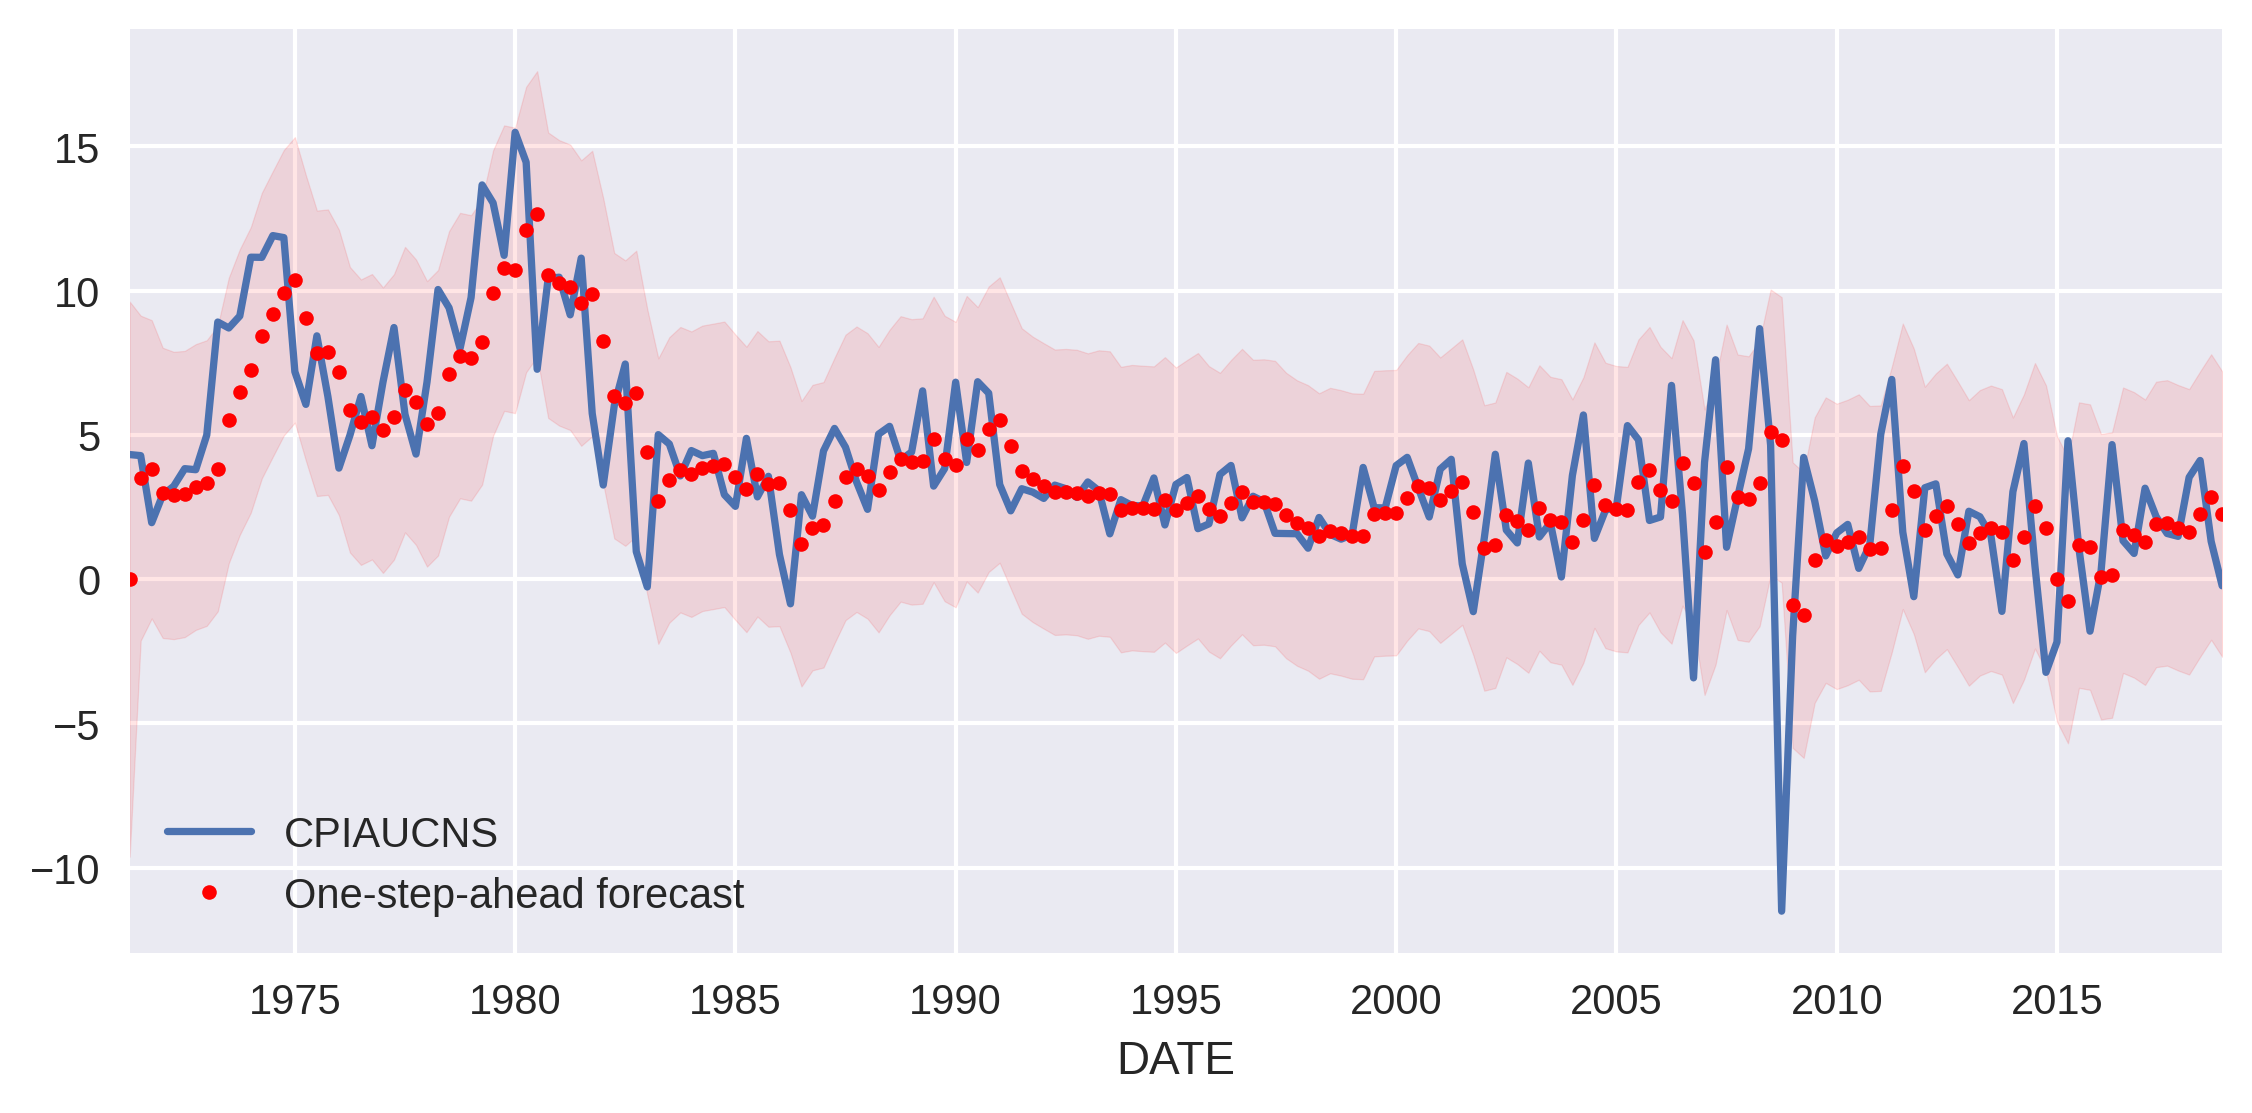

In [5]:
predict_mle = res_mle.get_prediction()
predict_mle_ci = predict_mle.conf_int()
lower = predict_mle_ci["lower CPIAUCNS"]
upper = predict_mle_ci["upper CPIAUCNS"]

# Graph
fig, ax = plt.subplots(figsize=(9, 4), dpi=300)

# Plot data points
inf.plot(ax=ax, style="-", label="Observed")

# Plot predictions
predict_mle.predicted_mean.plot(ax=ax, style="r.", label="One-step-ahead forecast")
ax.fill_between(predict_mle_ci.index, lower, upper, color="r", alpha=0.1)
ax.legend(loc="lower left")
plt.show()

### 4. Helper functions to provide tensors to the library doing Bayesian estimation

We're almost on to the magic but there are a few preliminaries. Feel free to skip this section if you're not interested in the technical details.

### Technical Details

PyMC3 is a Bayesian estimation library ("Probabilistic Programming in Python: Bayesian Modeling and Probabilistic Machine Learning with Theano") that is a) fast and b) optimized for Bayesian machine learning, for instance [Bayesian neural networks](https://docs.pymc.io/notebooks/bayesian_neural_network_advi.html). To do all of this, it is built on top of a Theano, a library that aims to evaluate tensors very efficiently and provide symbolic differentiation (necessary for any kind of deep learning). It is the symbolic differentiation that means PyMC3 can use NUTS on any problem formulated within PyMC3.

We are not formulating a problem directly in PyMC3; we're using statsmodels to specify the statespace model and solve it with the Kalman filter. So we need to put the plumbing of statsmodels and PyMC3 together, which means wrapping the statsmodels SARIMAX model object in a Theano-flavored wrapper before passing information to PyMC3 for estimation.

Because of this, we can't use the Theano auto-differentiation directly. Happily, statsmodels SARIMAX objects have a method to return the Jacobian evaluated at the parameter values. We'll be making use of this to provide gradients so that we can use NUTS.

#### Defining helper functions to translate models into a PyMC3 friendly form

First, we'll create the Theano wrappers. They will be in the form of 'Ops', operation objects, that 'perform' particular tasks. They are initialized with a statsmodels `model` instance.

Although this code may look somewhat opaque, it is generic for any state space model in statsmodels.

In [6]:
class Loglike(tt.Op):

    itypes = [tt.dvector]  # expects a vector of parameter values when called
    otypes = [tt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, model):
        self.model = model
        self.score = Score(self.model)

    def perform(self, node, inputs, outputs):
        (theta,) = inputs  # contains the vector of parameters
        llf = self.model.loglike(theta)
        outputs[0][0] = np.array(llf)  # output the log-likelihood

    def grad(self, inputs, g):
        # the method that calculates the gradients - it actually returns the
        # vector-Jacobian product - g[0] is a vector of parameter values
        (theta,) = inputs  # our parameters
        out = [g[0] * self.score(theta)]
        return out


class Score(tt.Op):
    itypes = [tt.dvector]
    otypes = [tt.dvector]

    def __init__(self, model):
        self.model = model

    def perform(self, node, inputs, outputs):
        (theta,) = inputs
        outputs[0][0] = self.model.score(theta)

### 5. Bayesian estimation with NUTS

The next step is to set the parameters for the Bayesian estimation, specify our priors, and run it.

In [7]:
# Set sampling params
ndraws = 3000  # number of draws from the distribution
nburn = 600  # number of "burn-in points" (which will be discarded)

Now for the fun part! There are three parameters to estimate: $\phi$, $\theta_1$, and $\sigma$. We'll use uninformative uniform priors for the first two, and an inverse gamma for the last one. Then we'll run the inference optionally using as many computer cores as I have.

In [8]:
# Construct an instance of the Theano wrapper defined above, which
# will allow PyMC3 to compute the likelihood and Jacobian in a way
# that it can make use of. Here we are using the same model instance
# created earlier for MLE analysis (we could also create a new model
# instance if we preferred)
loglike = Loglike(mod)

with pm.Model() as m:
    # Priors
    arL1 = pm.Uniform("ar.L1", -0.99, 0.99)
    maL1 = pm.Uniform("ma.L1", -0.99, 0.99)
    sigma2 = pm.InverseGamma("sigma2", 2, 4)

    # convert variables to tensor vectors
    theta = tt.as_tensor_variable([arL1, maL1, sigma2])

    # use a DensityDist (use a lamdba function to "call" the Op)
    pm.DensityDist("likelihood", loglike, observed=theta)

    # Draw samples
    trace = pm.sample(
        ndraws,
        tune=nburn,
        return_inferencedata=True,
        cores=1,
        compute_convergence_checks=False,
    )

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Sequential sampling (2 chains in 1 job)


NUTS: [sigma2, ma.L1, ar.L1]


Sampling 2 chains for 600 tune and 3_000 draw iterations (1_200 + 6_000 draws total) took 192 seconds.


There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


Note that the NUTS sampler is auto-assigned because we provided gradients. PyMC3 will use Metropolis or Slicing samplers if it does not find that gradients are available. There are an impressive number of draws per second for a "block box" style computation! However, note that if the model can be represented directly by PyMC3 (like the AR(p) models mentioned above), then computation can be substantially faster.

Inference is complete, but are the results any good? There are a number of ways to check. The first is to look at the posterior distributions (with lines showing the MLE values):

<Figure size 800x550 with 0 Axes>

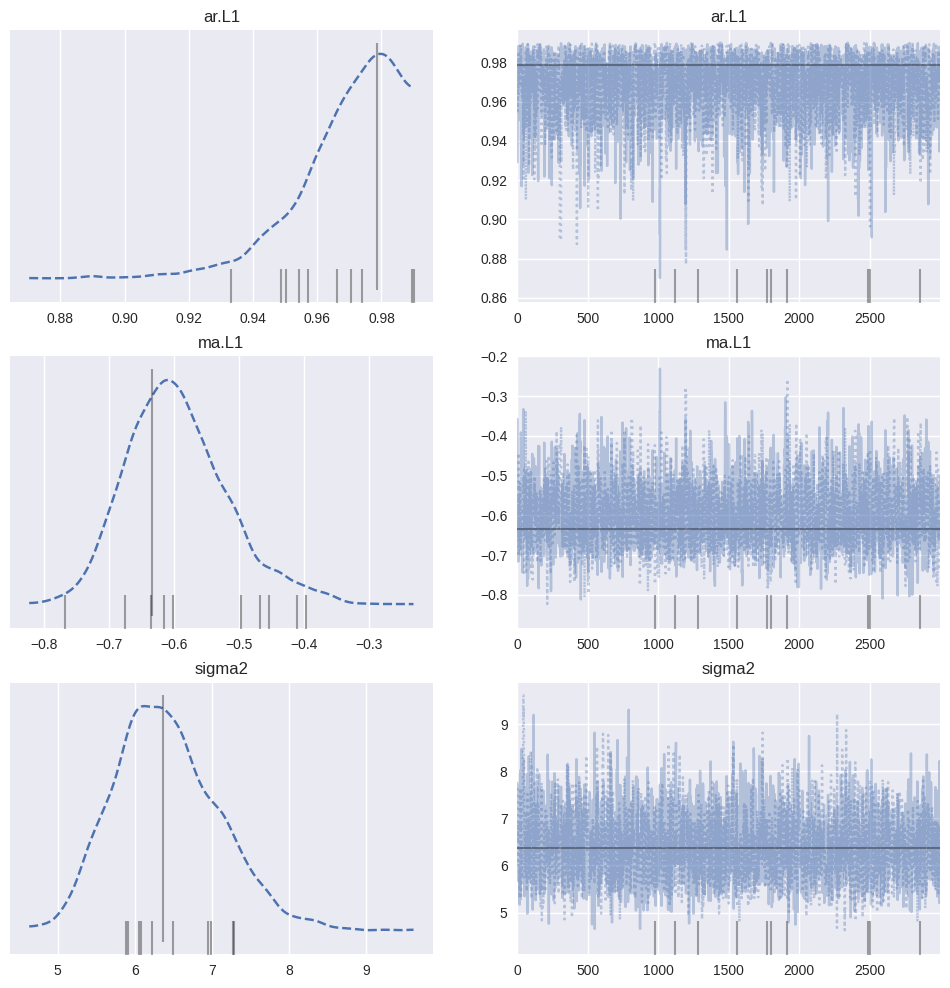

In [9]:
plt.tight_layout()
# Note: the syntax here for the lines argument is required for
# PyMC3 versions >= 3.7
# For version <= 3.6 you can use lines=dict(res_mle.params) instead
_ = pm.plot_trace(
    trace,
    lines=[(k, {}, [v]) for k, v in dict(res_mle.params).items()],
    combined=True,
    figsize=(12, 12),
)

The estimated posteriors clearly peak close to the parameters found by MLE. We can also see a summary of the estimated values:

In [10]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ar.L1,0.969,0.016,0.941,0.990,0.000,0.000,1726.0,1843.0,1.0
ma.L1,-0.594,0.079,-0.733,-0.436,0.002,0.001,2220.0,1784.0,1.0
sigma2,6.418,0.681,5.294,7.770,0.014,0.010,2520.0,2642.0,1.0


Here $\hat{R}$ is the Gelman-Rubin statistic. It tests for lack of convergence by comparing the variance between multiple chains to the variance within each chain. If convergence has been achieved, the between-chain and within-chain variances should be identical. If $\hat{R}<1.2$ for all model parameters, we can have some confidence that convergence has been reached.

Additionally, the highest posterior density interval (the gap between the two values of HPD in the table) is small for each of the variables.

### 6. Application of Bayesian estimates of parameters

We'll now re-instigate a version of the model but using the parameters from the Bayesian estimation, and again plot the one-step-ahead forecasts.

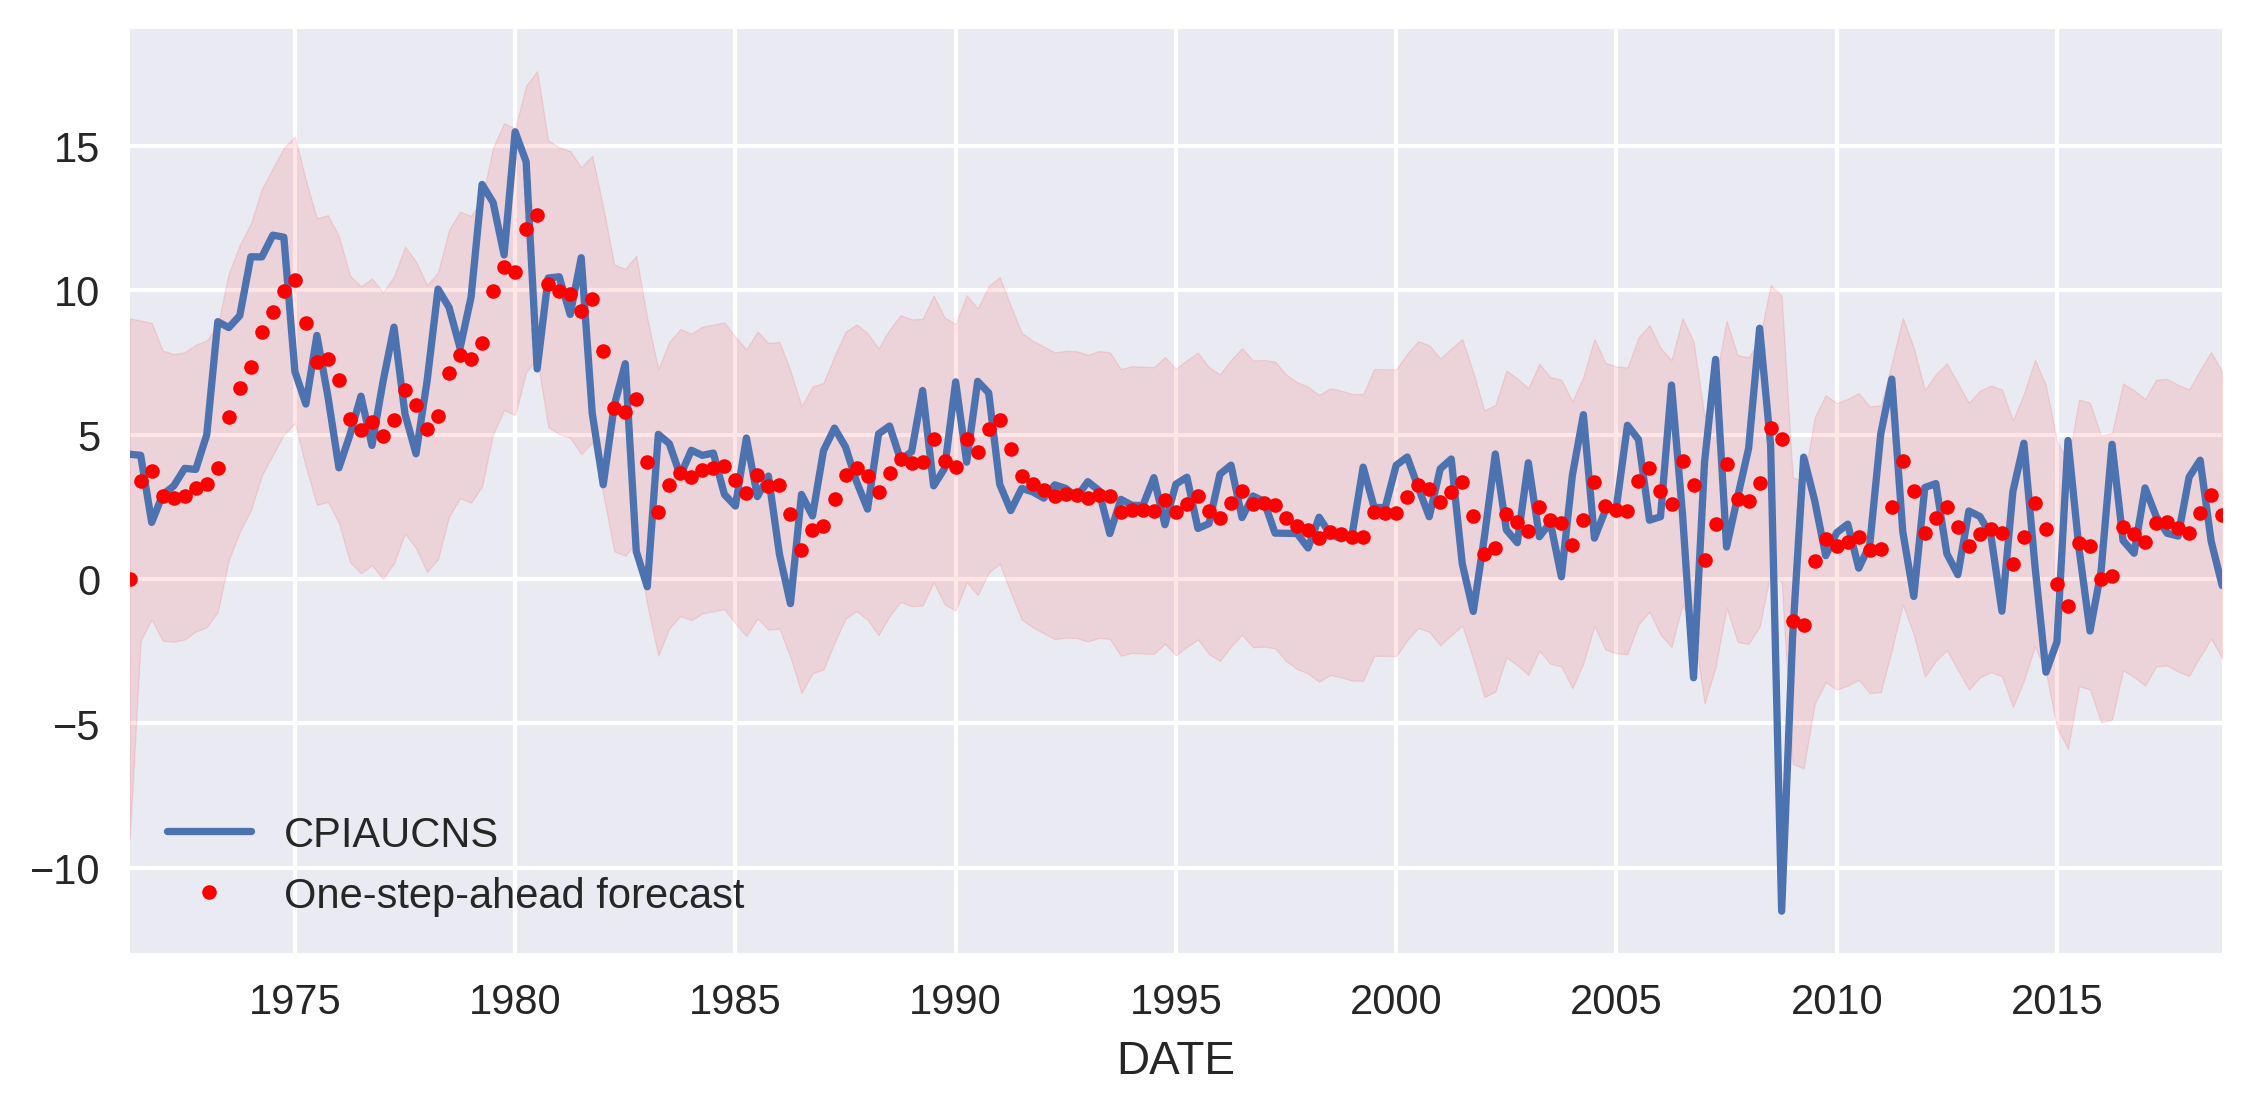

In [11]:
# Retrieve the posterior means
params = pm.summary(trace)["mean"].values

# Construct results using these posterior means as parameter values
res_bayes = mod.smooth(params)

predict_bayes = res_bayes.get_prediction()
predict_bayes_ci = predict_bayes.conf_int()
lower = predict_bayes_ci["lower CPIAUCNS"]
upper = predict_bayes_ci["upper CPIAUCNS"]

# Graph
fig, ax = plt.subplots(figsize=(9, 4), dpi=300)

# Plot data points
inf.plot(ax=ax, style="-", label="Observed")

# Plot predictions
predict_bayes.predicted_mean.plot(ax=ax, style="r.", label="One-step-ahead forecast")
ax.fill_between(predict_bayes_ci.index, lower, upper, color="r", alpha=0.1)
ax.legend(loc="lower left")
plt.show()

## Appendix A. Application to `UnobservedComponents` models

We can reuse the `Loglike` and `Score` wrappers defined above to consider a different state space model. For example, we might want to model inflation as the combination of a random walk trend and autoregressive error term:

$$
\begin{aligned}
y_t & = \mu_t + \varepsilon_t \\
\mu_t & = \mu_{t-1} + \eta_t \\
\varepsilon_t &= \phi \varepsilon_t + \zeta_t
\end{aligned}
$$

This model can be constructed in Statsmodels with the `UnobservedComponents` class using the `rwalk` and `autoregressive` specifications. As before, we can fit the model using maximum likelihood via the `fit` method.

In [12]:
# Construct the model instance
mod_uc = sm.tsa.UnobservedComponents(inf, "rwalk", autoregressive=1)

# Fit the model via maximum likelihood
res_uc_mle = mod_uc.fit()
print(res_uc_mle.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.43820D+00    |proj g|=  1.07332D-01

At iterate    5    f=  2.31427D+00    |proj g|=  2.20639D-02

At iterate   10    f=  2.30814D+00    |proj g|=  1.67045D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     14      1     0     0   7.403D-08   2.308D+00
  F =   2.3081388933012512     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                        Unobserved Components Results                 

 This problem is unconstrained.


As noted earlier, the Theano wrappers (`Loglike` and `Score`) that we created above are generic, so we can re-use essentially the same code to explore the model with Bayesian methods.

In [13]:
# Set sampling params
ndraws = 3000  # number of draws from the distribution
nburn = 600  # number of "burn-in points" (which will be discarded)

In [14]:
# Here we follow the same procedure as above, but now we instantiate the
# Theano wrapper `Loglike` with the UC model instance instead of the
# SARIMAX model instance
loglike_uc = Loglike(mod_uc)

with pm.Model():
    # Priors
    sigma2level = pm.InverseGamma("sigma2.level", 1, 1)
    sigma2ar = pm.InverseGamma("sigma2.ar", 1, 1)
    arL1 = pm.Uniform("ar.L1", -0.99, 0.99)

    # convert variables to tensor vectors
    theta_uc = tt.as_tensor_variable([sigma2level, sigma2ar, arL1])

    # use a DensityDist (use a lamdba function to "call" the Op)
    pm.DensityDist("likelihood", loglike_uc, observed=theta_uc)

    # Draw samples
    trace_uc = pm.sample(
        ndraws,
        tune=nburn,
        return_inferencedata=True,
        cores=1,
        compute_convergence_checks=False,
    )

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Sequential sampling (2 chains in 1 job)


NUTS: [ar.L1, sigma2.ar, sigma2.level]


Sampling 2 chains for 600 tune and 3_000 draw iterations (1_200 + 6_000 draws total) took 76 seconds.


And as before we can plot the marginal posteriors. In contrast to the SARIMAX example, here the posterior modes are somewhat different from the MLE estimates.

<Figure size 800x550 with 0 Axes>

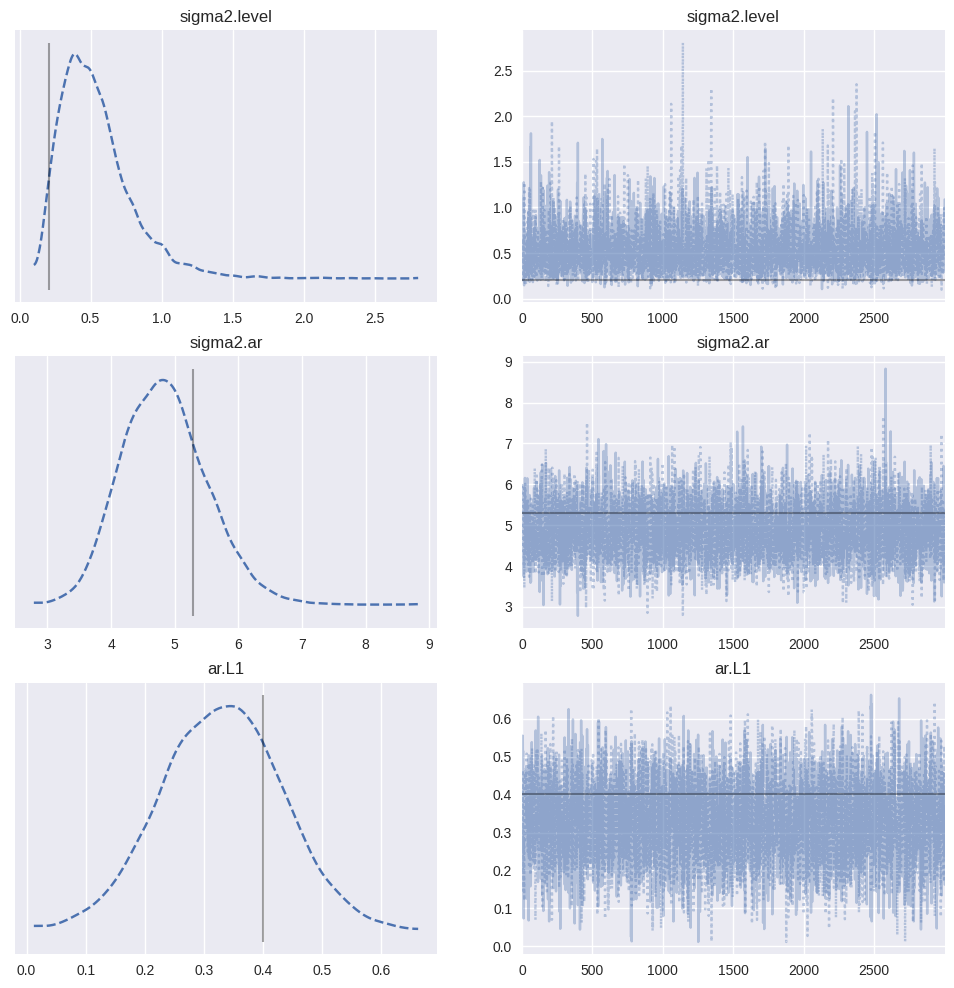

In [15]:
plt.tight_layout()
# Note: the syntax here for the lines argument is required for
# PyMC3 versions >= 3.7
# For version <= 3.6 you can use lines=dict(res_mle.params) instead
_ = pm.plot_trace(
    trace_uc,
    lines=[(k, {}, [v]) for k, v in dict(res_uc_mle.params).items()],
    combined=True,
    figsize=(12, 12),
)

In [16]:
pm.summary(trace_uc)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma2.level,0.538,0.260,0.151,0.999,0.004,0.003,4081.0,3970.0,1.0
sigma2.ar,4.843,0.667,3.603,6.061,0.010,0.007,4051.0,3782.0,1.0
ar.L1,0.329,0.102,0.138,0.523,0.002,0.001,4249.0,4450.0,1.0


In [17]:
# Retrieve the posterior means
params = pm.summary(trace_uc)["mean"].values

# Construct results using these posterior means as parameter values
res_uc_bayes = mod_uc.smooth(params)

One benefit of this model is that it gives us an estimate of the underling "level" of inflation, using the smoothed estimate of $\mu_t$, which we can access as the "level" column in the results objects' `states.smoothed` attribute. In this case, because the Bayesian posterior mean of the level's variance is larger than the MLE estimate, its estimated level is a little more volatile.

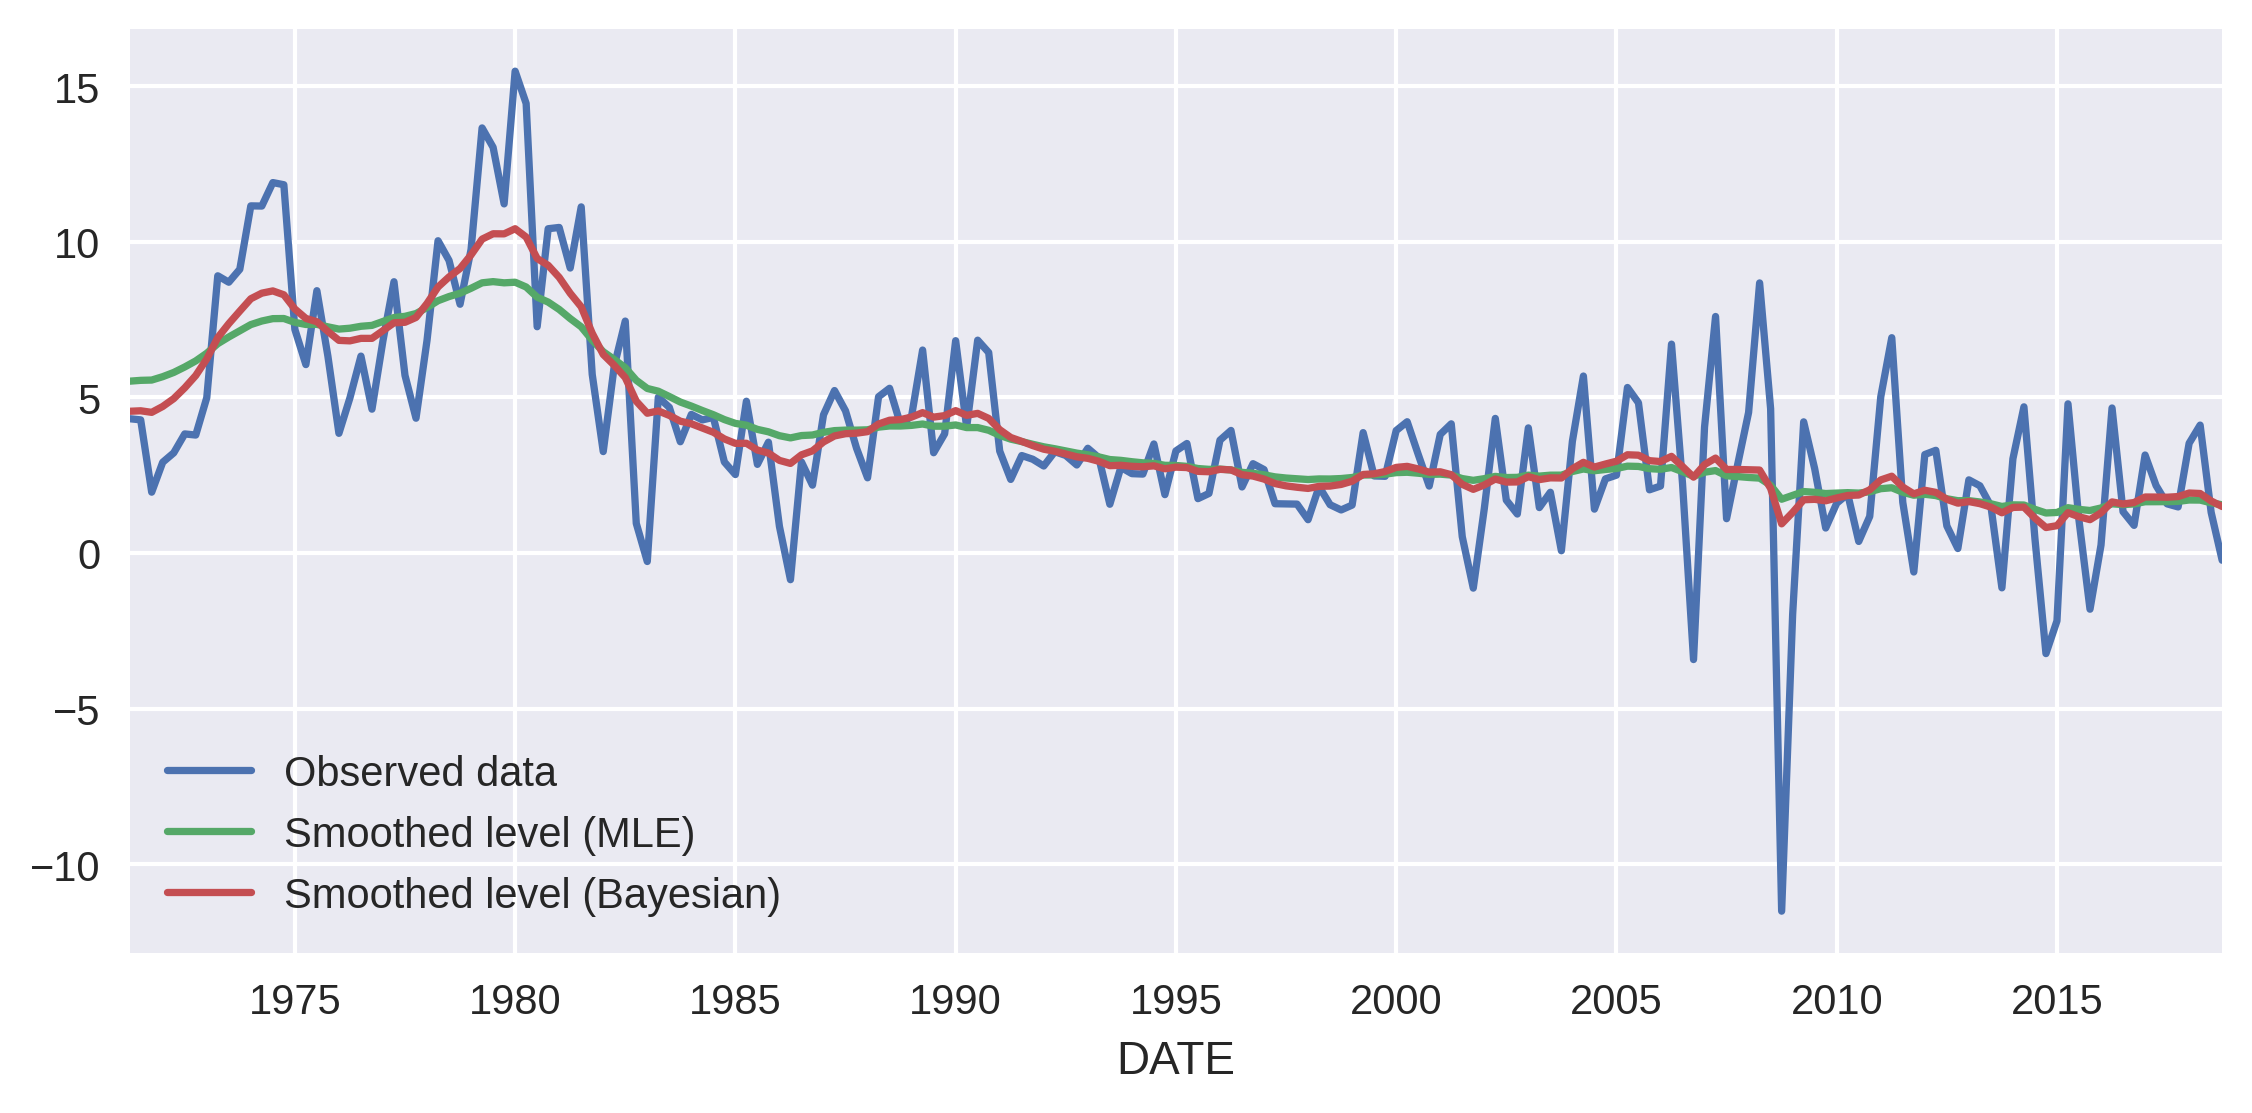

In [18]:
# Graph
fig, ax = plt.subplots(figsize=(9, 4), dpi=300)

# Plot data points
inf["CPIAUCNS"].plot(ax=ax, style="-", label="Observed data")

# Plot estimate of the level term
res_uc_mle.states.smoothed["level"].plot(ax=ax, label="Smoothed level (MLE)")
res_uc_bayes.states.smoothed["level"].plot(ax=ax, label="Smoothed level (Bayesian)")

ax.legend(loc="lower left");